<a href="https://colab.research.google.com/github/charecktowa/Chemistry-ML/blob/main/103_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dive into Neural Network Activation Functions
## A Comprehensive Guide with Theory, Implementation, and Applications

This notebook provides a thorough exploration of activation functions in neural networks,
covering everything from basic concepts to advanced applications.

## Table of Contents
1. Introduction to Activation Functions  
2. Mathematical Foundations  
3. Classic Activation Functions  
4. Modern Activation Functions  
5. Comparative Analysis  
6. Practical Implementation  
7. Applications and Use Cases  
8. Troubleshooting Common Issues  
9. Advanced Topics  
10. Hands-on Experiments  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Chapter 1: Introduction to Activation Functions
Activation functions are mathematical operations applied at the output of each neuron.

They are crucial for enabling the network to learn complex, non-linear mappings. Without them,
a neural network would just be a linear regression model regardless of depth.

We'll now explore how different activation functions behave and how they affect learning.


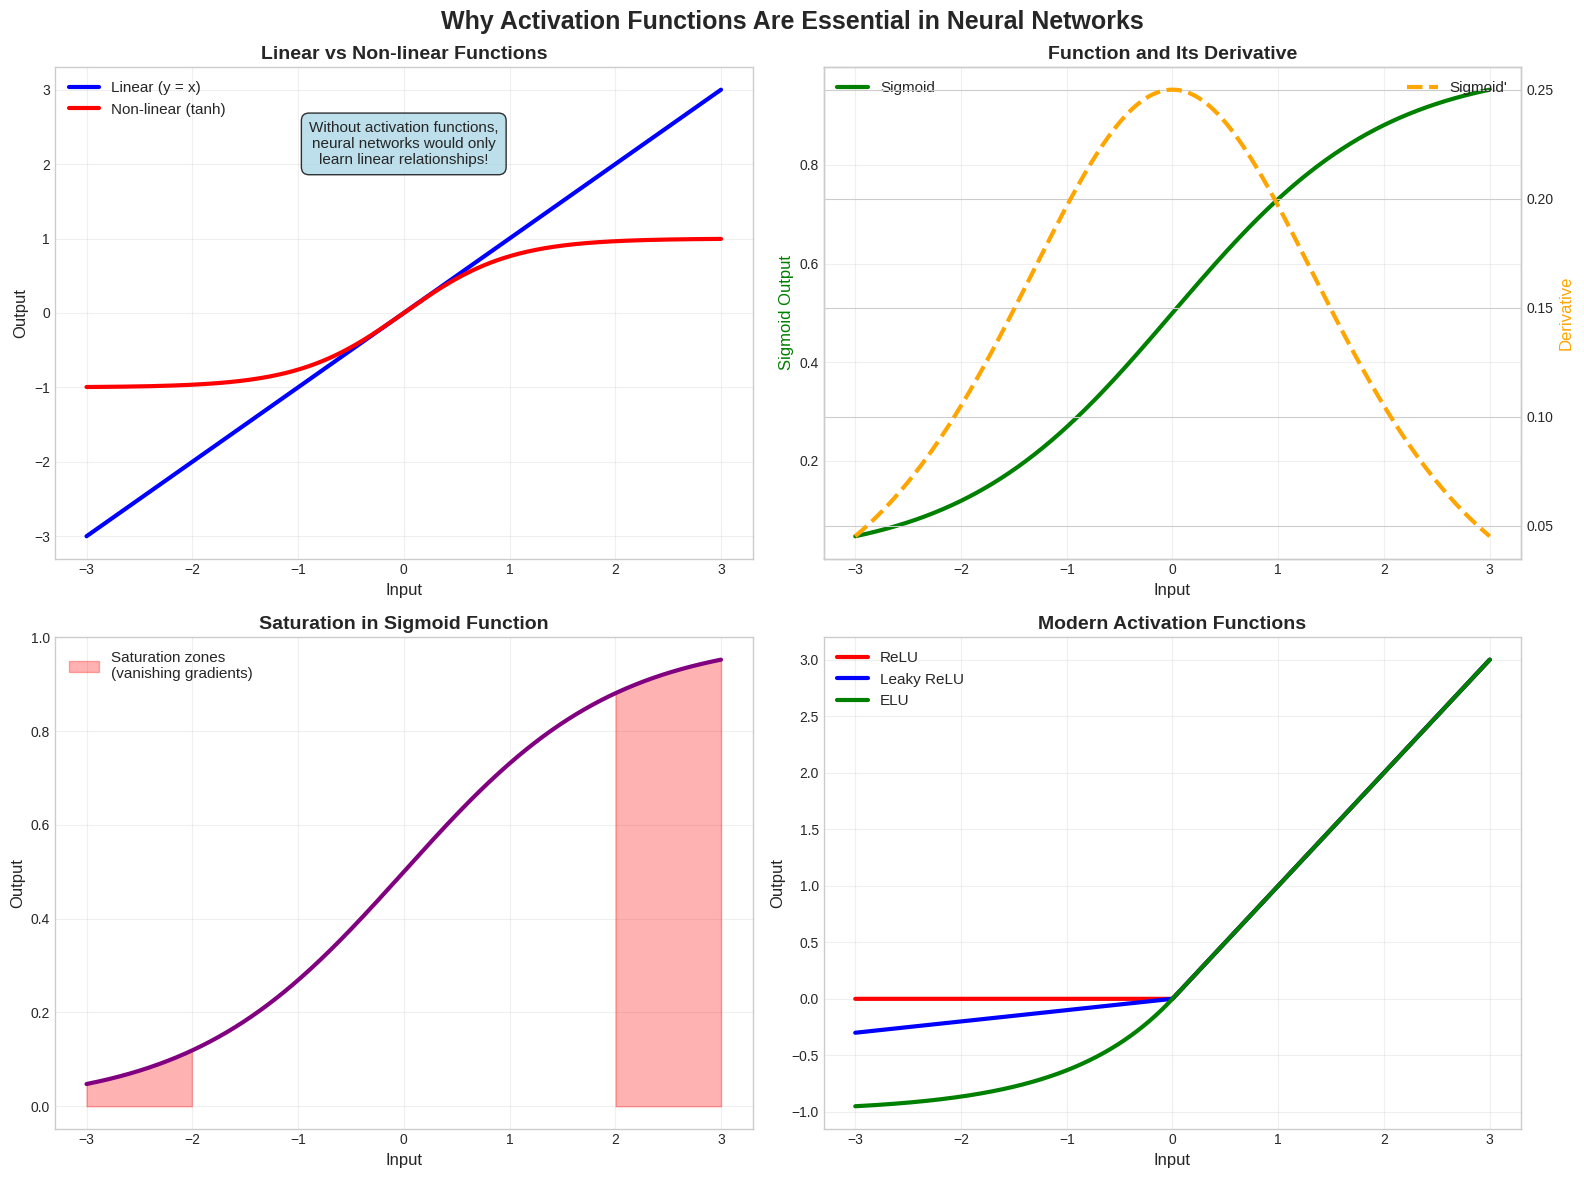

In [ ]:
def create_introduction_visualization():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    x = np.linspace(-3, 3, 1000)

    linear = x
    nonlinear = np.tanh(x)

    ax1.plot(x, linear, 'b-', linewidth=3, label='Linear (y = x)')
    ax1.plot(x, nonlinear, 'r-', linewidth=3, label='Non-linear (tanh)')
    ax1.set_title('Linear vs Non-linear Functions', fontweight='bold')
    ax1.set_xlabel('Input')
    ax1.set_ylabel('Output')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0, 2, 'Without activation functions,\nneural networks would only\nlearn linear relationships!',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
             ha='center', fontsize=11)

    sigmoid = 1 / (1 + np.exp(-x))
    sigmoid_derivative = sigmoid * (1 - sigmoid)
    ax2.plot(x, sigmoid, 'g-', linewidth=3, label='Sigmoid')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(x, sigmoid_derivative, 'orange', linewidth=3, linestyle='--', label="Sigmoid'")
    ax2.set_title('Function and Its Derivative', fontweight='bold')
    ax2.set_xlabel('Input')
    ax2.set_ylabel('Sigmoid Output', color='green')
    ax2_twin.set_ylabel('Derivative', color='orange')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    ax3.plot(x, sigmoid, 'purple', linewidth=3)
    ax3.fill_between(x, 0, sigmoid, where=(x < -2), alpha=0.3, color='red',
                     label='Saturation zones\n(vanishing gradients)')
    ax3.fill_between(x, 0, sigmoid, where=(x > 2), alpha=0.3, color='red')
    ax3.set_title('Saturation in Sigmoid Function', fontweight='bold')
    ax3.set_xlabel('Input')
    ax3.set_ylabel('Output')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    relu = np.maximum(0, x)
    leaky_relu = np.where(x > 0, x, 0.1 * x)
    elu = np.where(x > 0, x, np.exp(x) - 1)

    ax4.plot(x, relu, 'red', linewidth=3, label='ReLU')
    ax4.plot(x, leaky_relu, 'blue', linewidth=3, label='Leaky ReLU')
    ax4.plot(x, elu, 'green', linewidth=3, label='ELU')
    ax4.set_title('Modern Activation Functions', fontweight='bold')
    ax4.set_xlabel('Input')
    ax4.set_ylabel('Output')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('Why Activation Functions Are Essential in Neural Networks',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

create_introduction_visualization()

#  Chapter 2: Mathematical Foundations

To study and compare activation functions rigorously, we define a general-purpose base class.

This class supports:
- Evaluating the function at any input
- Estimating its derivative using finite differences
- Visualizing both function and gradient
- Analyzing core properties: range, monotonicity, vanishing gradients, etc.



In [ ]:
class ActivationFunction:
    def __init__(self, name):
        self.name = name

    def forward(self, x):
        raise NotImplementedError

    def derivative(self, x):
        h = 1e-7
        return (self.forward(x + h) - self.forward(x - h)) / (2 * h)

    def plot(self, x_range=(-5, 5), show_derivative=True):
        x = np.linspace(x_range[0], x_range[1], 1000)
        y = self.forward(x)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(x, y, 'b-', linewidth=3, label=f'{self.name}')
        ax1.set_title(f'{self.name} Activation Function', fontweight='bold')
        ax1.set_xlabel('Input (x)')
        ax1.set_ylabel(f'{self.name}(x)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        if show_derivative:
            dy = self.derivative(x)
            ax2.plot(x, dy, 'r-', linewidth=3, label=f"{self.name}'")
            ax2.set_title(f'{self.name} Derivative', fontweight='bold')
            ax2.set_xlabel('Input (x)')
            ax2.set_ylabel(f"d/dx {self.name}(x)")
            ax2.grid(True, alpha=0.3)
            ax2.legend()

        plt.tight_layout()
        plt.show()

        self.analyze_properties(x, y, dy if show_derivative else None)

    def analyze_properties(self, x, y, dy=None):
        print(f"\nAnalysis of {self.name.upper()}:")
        print(f"Range: [{np.min(y):.3f}, {np.max(y):.3f}]")
        print(f"Zero-centered: {'Yes' if np.any(y < 0) and np.any(y > 0) else 'No'}")
        print(f"Monotonic: {'Yes' if np.all(np.diff(y) >= 0) or np.all(np.diff(y) <= 0) else 'No'}")
        if dy is not None:
            print(f"Max derivative: {np.max(dy):.3f}")
            print(f"Vanishing gradient risk: {'High' if np.max(dy) < 0.5 else 'Low'}")
            saturated = np.sum(np.abs(dy) < 0.01) / len(dy) * 100
            print(f"Saturation: {saturated:.1f}% of inputs")

# Chapter 3: Classic Activation Functions
Now let's implement and visualize some of the earliest activation functions used in neural networks:

- **Step Function** – outputs 0 or 1; non-differentiable.
- **Linear Function** – identity, no transformation.
- **Sigmoid** – squashes values into [0,1], but suffers from vanishing gradients.
- **Tanh** – similar to sigmoid, but zero-centered.

In [ ]:
class StepFunction(ActivationFunction):
    def __init__(self):
        super().__init__("Step")
    def forward(self, x):
        return np.where(x >= 0, 1.0, 0.0)

class LinearFunction(ActivationFunction):
    def __init__(self):
        super().__init__("Linear")
    def forward(self, x):
        return x

class SigmoidFunction(ActivationFunction):
    def __init__(self):
        super().__init__("Sigmoid")
    def forward(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    def derivative(self, x):
        s = self.forward(x)
        return s * (1 - s)

class TanhFunction(ActivationFunction):
    def __init__(self):
        super().__init__("Tanh")
    def forward(self, x):
        return np.tanh(x)
    def derivative(self, x):
        t = self.forward(x)
        return 1 - t**2

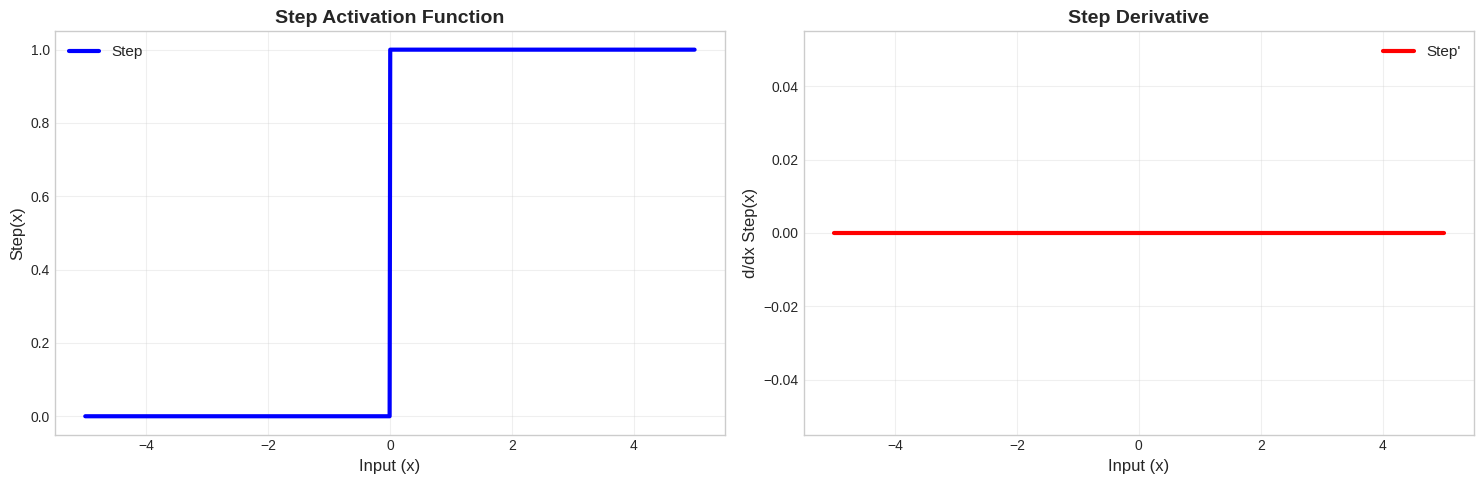


Analysis of STEP:
Range: [0.000, 1.000]
Zero-centered: No
Monotonic: Yes
Max derivative: 0.000
Vanishing gradient risk: High
Saturation: 100.0% of inputs


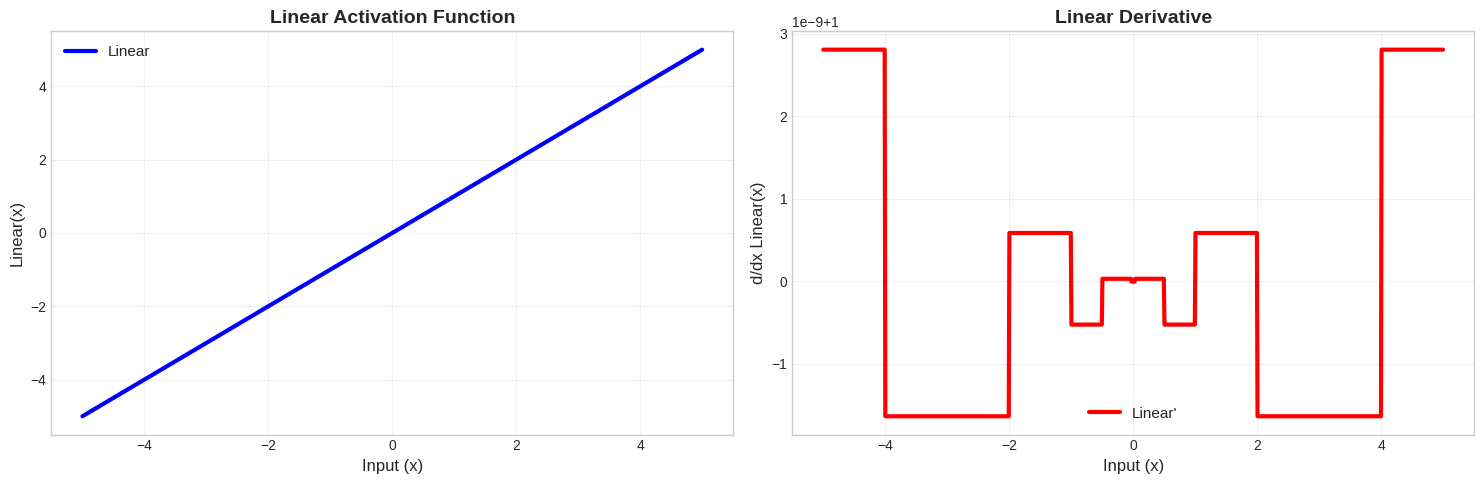


Analysis of LINEAR:
Range: [-5.000, 5.000]
Zero-centered: Yes
Monotonic: Yes
Max derivative: 1.000
Vanishing gradient risk: Low
Saturation: 0.0% of inputs


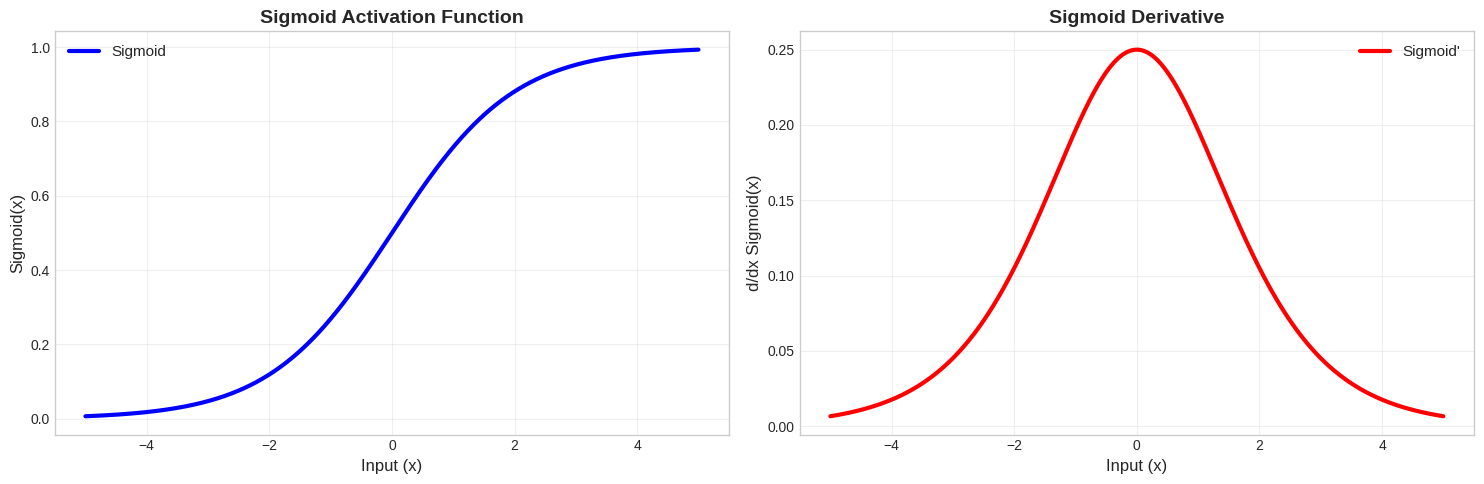


Analysis of SIGMOID:
Range: [0.007, 0.993]
Zero-centered: No
Monotonic: Yes
Max derivative: 0.250
Vanishing gradient risk: High
Saturation: 8.4% of inputs


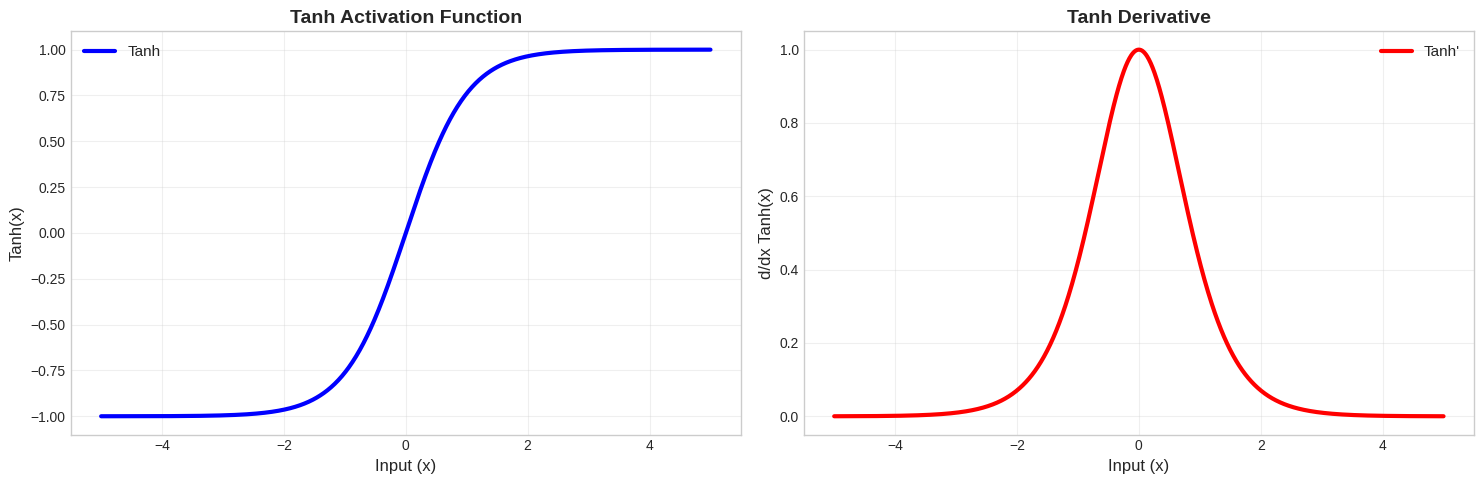


Analysis of TANH:
Range: [-1.000, 1.000]
Zero-centered: Yes
Monotonic: Yes
Max derivative: 1.000
Vanishing gradient risk: Low
Saturation: 40.2% of inputs


In [ ]:
classic_functions = [
    StepFunction(),
    LinearFunction(),
    SigmoidFunction(),
    TanhFunction()
]

for func in classic_functions:
    func.plot()

#### ✅ Step
- Binary threshold.
- ❌ No gradient – cannot be used in backpropagation.

#### ✅ Linear
- Just `y = x`.
- ❌ No non-linearity, useless in deep networks.

#### ✅ Sigmoid
- Smooth, bounded output [0, 1].
- ❌ Not zero-centered.
- ❌ Vanishing gradients for large |x|.

#### ✅ Tanh
- Similar to sigmoid but output in [-1, 1].
- ✅ Zero-centered.
- ❌ Still suffers from vanishing gradients.

# Chapter 4: Modern Activation Functions
Modern activation functions were designed to address the issues of earlier functions like sigmoid and tanh.

We’ll focus on the following:
- **ReLU** – fast, efficient, but can cause dead neurons.
- **Leaky ReLU** – allows small gradient when `x < 0`.
- **ELU** – smooth alternative to ReLU with negative values.
- **GELU** – used in Transformers; probabilistic and smooth.


In [ ]:
class ReLUFunction(ActivationFunction):
    def __init__(self):
        super().__init__("ReLU")
    def forward(self, x):
        return np.maximum(0, x)
    def derivative(self, x):
        return np.where(x > 0, 1.0, 0.0)

class LeakyReLUFunction(ActivationFunction):
    def __init__(self, alpha=0.01):
        super().__init__(f"Leaky ReLU (α={alpha})")
        self.alpha = alpha
    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)
    def derivative(self, x):
        return np.where(x > 0, 1.0, self.alpha)

class ELUFunction(ActivationFunction):
    def __init__(self, alpha=1.0):
        super().__init__(f"ELU (α={alpha})")
        self.alpha = alpha
    def forward(self, x):
        return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))
    def derivative(self, x):
        return np.where(x > 0, 1.0, self.alpha * np.exp(x))

class GeluFunction(ActivationFunction):
    def __init__(self):
        super().__init__("GELU")
    def forward(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715*x**3)))

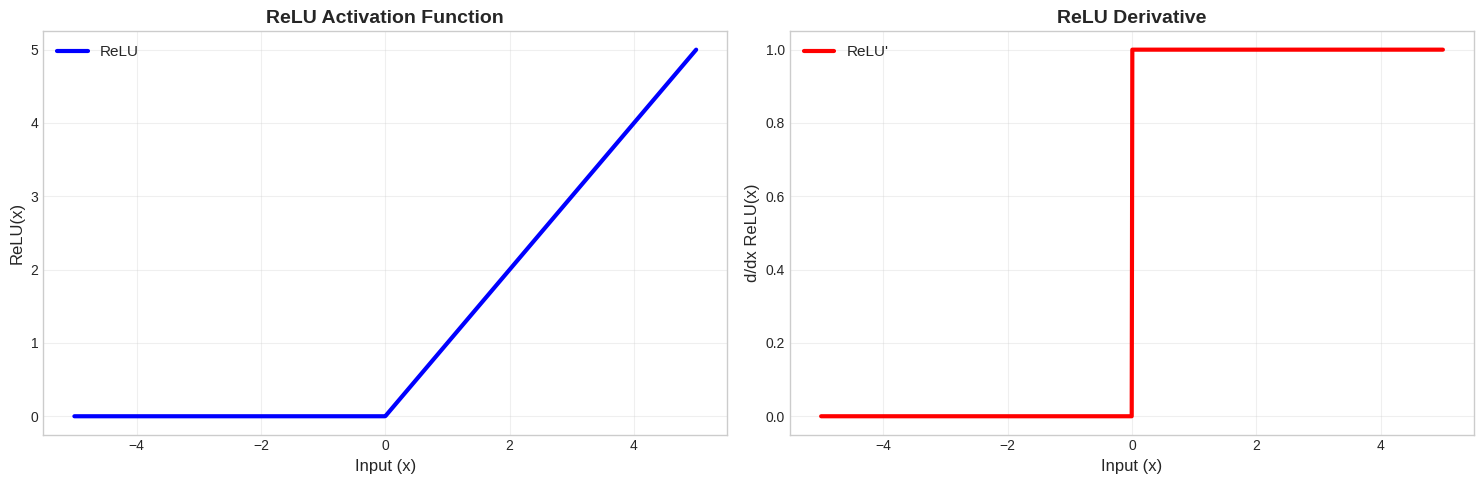


Analysis of RELU:
Range: [0.000, 5.000]
Zero-centered: No
Monotonic: Yes
Max derivative: 1.000
Vanishing gradient risk: Low
Saturation: 50.0% of inputs


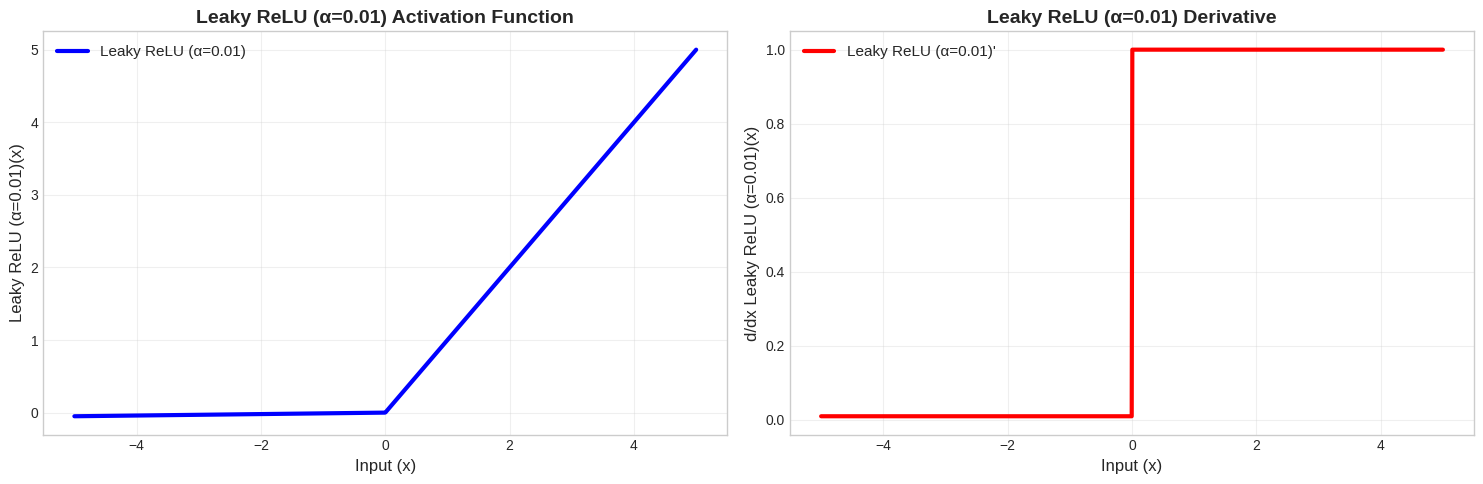


Analysis of LEAKY RELU (Α=0.01):
Range: [-0.050, 5.000]
Zero-centered: Yes
Monotonic: Yes
Max derivative: 1.000
Vanishing gradient risk: Low
Saturation: 0.0% of inputs


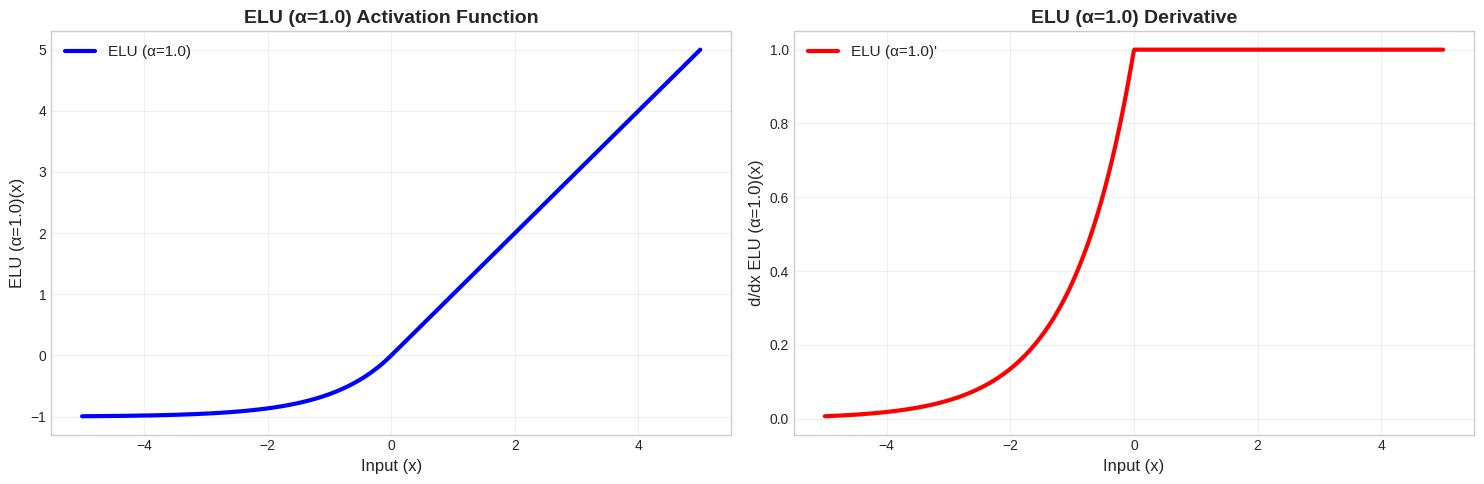


Analysis of ELU (Α=1.0):
Range: [-0.993, 5.000]
Zero-centered: Yes
Monotonic: Yes
Max derivative: 1.000
Vanishing gradient risk: Low
Saturation: 4.0% of inputs


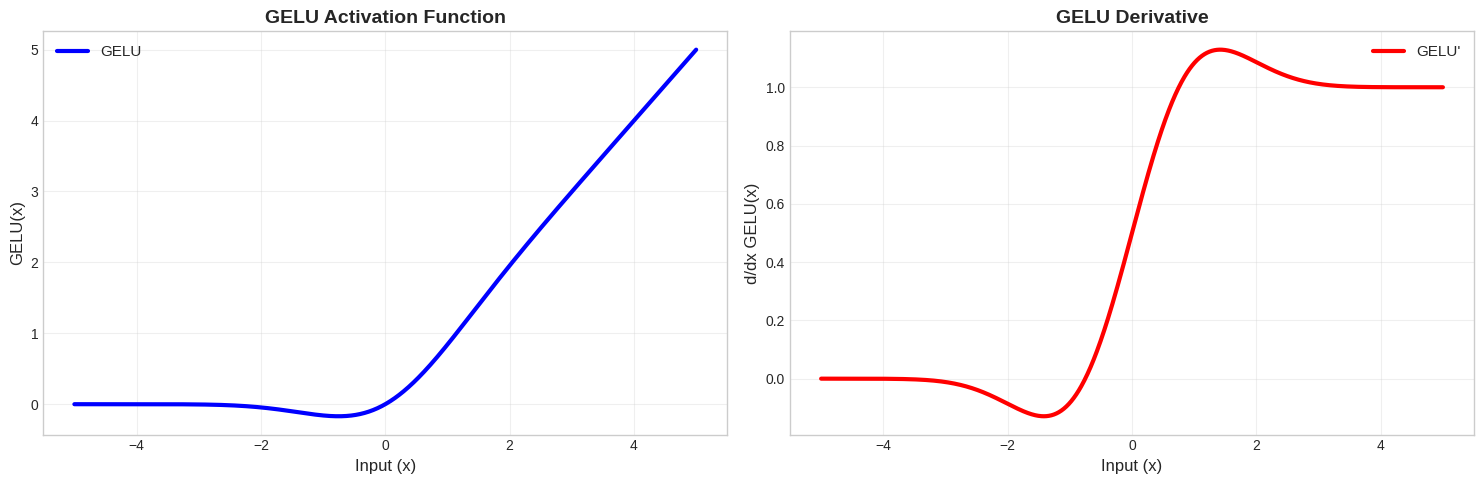


Analysis of GELU:
Range: [-0.170, 5.000]
Zero-centered: Yes
Monotonic: No
Max derivative: 1.129
Vanishing gradient risk: Low
Saturation: 20.0% of inputs


In [ ]:
modern_functions = [
    ReLUFunction(),
    LeakyReLUFunction(),
    ELUFunction(),
    GeluFunction()
]

for func in modern_functions:
    func.plot()

#### ✅ ReLU
- ✅ Fast, sparse, good gradients.
- ❌ Dead neuron issue when `x < 0`.

#### ✅ Leaky ReLU
- ✅ Prevents dying ReLU.
- ❌ Extra hyperparameter (α).

#### ✅ ELU
- ✅ Smooth gradients.
- ✅ Negative outputs → mean activations near zero.
- ❌ Slower than ReLU.

#### ✅ GELU
- ✅ Smooth and differentiable.
- ✅ Used in BERT/GPT.
- 🎯 Popular in NLP tasks.

# Chapter 5: Comparative Analysis
Let’s now compare all activation functions with respect to:
- Output range
- Zero-centeredness
- Monotonicity
- Maximum derivative
- Gradient flow risk

In [ ]:
def comprehensive_comparison():
    all_functions = classic_functions + modern_functions
    x = np.linspace(-3, 3, 1000)
    properties = []

    for func in all_functions:
        y = func.forward(x)
        dy = func.derivative(x)
        props = {
            'Name': func.name,
            'Range': f"[{np.min(y):.2f}, {np.max(y):.2f}]",
            'Zero-centered': 'Yes' if np.any(y < 0) and np.any(y > 0) else 'No',
            'Monotonic': 'Yes' if np.all(np.diff(y) >= 0) or np.all(np.diff(y) <= 0) else 'No',
            'Max Derivative': f"{np.max(dy):.3f}",
            'Vanishing Gradient': 'High' if np.max(dy) < 0.5 else 'Low'
        }
        properties.append(props)

    for prop in properties:
        print(f"{prop['Name']:<20} | Range: {prop['Range']:>14} | "
              f"Zero-centered: {prop['Zero-centered']:>3} | Monotonic: {prop['Monotonic']:>3} | "
              f"Max Deriv: {prop['Max Derivative']:>5} | Vanishing Grad: {prop['Vanishing Gradient']}")

In [ ]:
comprehensive_comparison()

Step                 | Range:   [0.00, 1.00] | Zero-centered:  No | Monotonic: Yes | Max Deriv: 0.000 | Vanishing Grad: High
Linear               | Range:  [-3.00, 3.00] | Zero-centered: Yes | Monotonic: Yes | Max Deriv: 1.000 | Vanishing Grad: Low
Sigmoid              | Range:   [0.05, 0.95] | Zero-centered:  No | Monotonic: Yes | Max Deriv: 0.250 | Vanishing Grad: High
Tanh                 | Range:  [-1.00, 1.00] | Zero-centered: Yes | Monotonic: Yes | Max Deriv: 1.000 | Vanishing Grad: Low
ReLU                 | Range:   [0.00, 3.00] | Zero-centered:  No | Monotonic: Yes | Max Deriv: 1.000 | Vanishing Grad: Low
Leaky ReLU (α=0.01)  | Range:  [-0.03, 3.00] | Zero-centered: Yes | Monotonic: Yes | Max Deriv: 1.000 | Vanishing Grad: Low
ELU (α=1.0)          | Range:  [-0.95, 3.00] | Zero-centered: Yes | Monotonic: Yes | Max Deriv: 1.000 | Vanishing Grad: Low
GELU                 | Range:  [-0.17, 3.00] | Zero-centered: Yes | Monotonic:  No | Max Deriv: 1.129 | Vanishing Grad: Low


# Chapter 6: Practical Implementation with PyTorch

Let’s put theory into practice by testing how different activation functions behave in real tasks.

We'll train small neural networks on:
- Binary classification
- Multi-class classification
- Regression

Each model will be identical in architecture, varying only the **activation function**.


In [ ]:
def create_datasets():
    X_bin, y_bin = make_classification(
        n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
        random_state=42, n_clusters_per_class=1, n_classes=2
    )

    X_multi, y_multi = make_classification(
        n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
        random_state=42, n_clusters_per_class=1, n_classes=3
    )

    X_reg, y_reg = make_regression(
        n_samples=1000, n_features=1, noise=0.1, random_state=42
    )

    scaler = StandardScaler()
    X_bin = scaler.fit_transform(X_bin)
    X_multi = scaler.fit_transform(X_multi)
    X_reg = scaler.fit_transform(X_reg)

    return (X_bin, y_bin), (X_multi, y_multi), (X_reg, y_reg)

binary_data, multi_data, reg_data = create_datasets()

In [ ]:
class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        super(FlexibleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

        activations = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(0.01),
            'elu': nn.ELU(),
            'gelu': nn.GELU()
        }
        self.activation = activations.get(activation, nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, task_type='classification', epochs=100):
    if task_type == 'classification':
        criterion = nn.BCEWithLogitsLoss() if model.output.out_features == 1 else nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_scores = []

    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)

            if task_type == 'classification' and model.output.out_features == 1:
                loss = criterion(output.squeeze(), batch_y.float())
            elif task_type == 'classification':
                loss = criterion(output, batch_y.long())
            else:
                loss = criterion(output.squeeze(), batch_y.float())

            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                if task_type == 'classification':
                    if model.output.out_features == 1:
                        pred = (torch.sigmoid(output.squeeze()) > 0.5).float()
                    else:
                        _, pred = torch.max(output, 1)
                    correct += (pred == batch_y).sum().item()
                    total += batch_y.size(0)
                else:
                    loss = criterion(output.squeeze(), batch_y.float())
                    total += 1
                    correct += loss.item()
        test_scores.append(100 * correct / total if task_type == 'classification' else correct / total)

    return train_losses, test_scores

In [ ]:
def compare_activations_on_dataset(X, y, task_type='classification', dataset_name=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train) if task_type == 'regression' else torch.LongTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test) if task_type == 'regression' else torch.LongTensor(y_test)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

    activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'elu', 'gelu']
    results = {}

    for act in activations:
        model = FlexibleNN(X.shape[1], 64, 1 if task_type == 'regression' or len(np.unique(y)) == 2 else len(np.unique(y)), act)
        losses, metrics = train_and_evaluate(model, train_loader, test_loader, task_type=task_type, epochs=50)
        results[act] = (losses, metrics)
        print(f"{act.title():<12}: Final {'Accuracy' if task_type=='classification' else 'MSE'} = {metrics[-1]:.3f}")

    return results

In [ ]:
print("\nRunning on Binary Classification Dataset:")
compare_activations_on_dataset(binary_data[0], binary_data[1], 'classification', 'Binary')

print("\nRunning on Multi-Class Classification Dataset:")
compare_activations_on_dataset(multi_data[0], multi_data[1], 'classification', 'Multi-class')

print("\nRunning on Regression Dataset:")
compare_activations_on_dataset(reg_data[0], reg_data[1], 'regression', 'Regression')


Running on Binary Classification Dataset:
Relu        : Final Accuracy = 93.000
Sigmoid     : Final Accuracy = 90.000
Tanh        : Final Accuracy = 90.500
Leaky_Relu  : Final Accuracy = 88.000
Elu         : Final Accuracy = 90.000
Gelu        : Final Accuracy = 89.500

Running on Multi-Class Classification Dataset:
Relu        : Final Accuracy = 90.000
Sigmoid     : Final Accuracy = 86.500
Tanh        : Final Accuracy = 89.000
Leaky_Relu  : Final Accuracy = 90.500
Elu         : Final Accuracy = 89.500
Gelu        : Final Accuracy = 89.500

Running on Regression Dataset:
Relu        : Final MSE = 1.113
Sigmoid     : Final MSE = 16.652
Tanh        : Final MSE = 8.093
Leaky_Relu  : Final MSE = 0.383
Elu         : Final MSE = 1.217
Gelu        : Final MSE = 0.725


{'relu': ([286.1593933105469,
   308.78338623046875,
   182.0823516845703,
   178.12452697753906,
   137.29673767089844,
   136.82899475097656,
   136.52162170410156,
   106.13731384277344,
   135.92062377929688,
   109.29476928710938,
   74.34097290039062,
   107.66757202148438,
   59.214012145996094,
   52.67319869995117,
   35.36237716674805,
   27.97646713256836,
   19.82876205444336,
   11.697721481323242,
   8.493804931640625,
   5.528981685638428,
   5.203724384307861,
   3.09148907661438,
   0.926000714302063,
   1.4673168659210205,
   2.210322856903076,
   4.291992664337158,
   3.5587315559387207,
   4.153195858001709,
   5.681269645690918,
   1.9850047826766968,
   2.7105607986450195,
   1.1726372241973877,
   1.777972936630249,
   1.118969202041626,
   4.240861892700195,
   1.3894273042678833,
   1.8338243961334229,
   1.4773695468902588,
   0.8086643815040588,
   0.572590708732605,
   0.6605837941169739,
   0.6459282040596008,
   1.4137245416641235,
   1.4117364883422852,
 

# Chapter 7: Applications and Use Cases
Activation functions are not just mathematical curiosities — they are selected based on the task, domain, and computational needs.

In this section, we provide a practical guide to choosing activation functions across different scenarios.


### Hidden Layers

- ✅ Shallow networks → ReLU
- ✅ Deep networks → ELU / GELU
- ❌ ReLU causing dead neurons? → Leaky ReLU

### Output Layer by Task

- ✅ Binary classification → Sigmoid
- ✅ Multi-class classification → Softmax
- ✅ Regression (unbounded) → Linear
- ✅ Regression (positive-only) → ReLU / Softplus

---

### By Domain

- 🧠 NLP → GELU (used in BERT, GPT)
- 👁️ CV → ReLU, Leaky ReLU, Swish (EfficientNet)
- 📉 Time Series → Tanh, GELU
- 🧬 Bio/Medical → ELU, GELU (smooth, stable)
- ⚙️ Real-time Systems → ReLU (fastest inference)


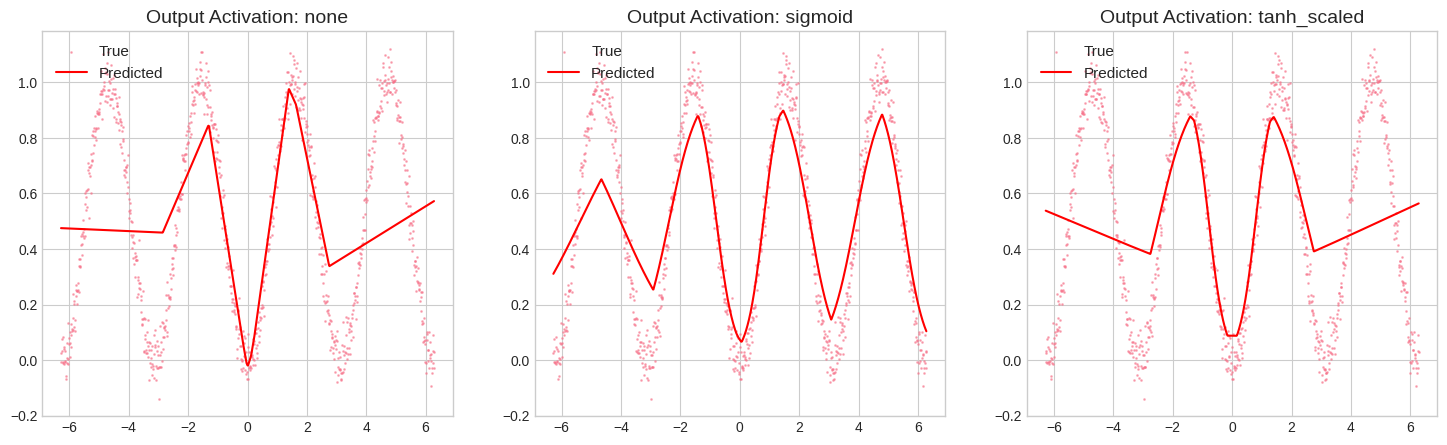

In [ ]:
# Predicting sin²(x) in [0, 1] using different output activations

x_bounded = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(-1, 1)
y_bounded = (np.sin(x_bounded) ** 2).ravel() + 0.05 * np.random.randn(1000)

class BoundedRegressionNet(nn.Module):
    def __init__(self, output_activation='sigmoid'):
        super().__init__()
        self.hidden = nn.Linear(1, 32)
        self.output = nn.Linear(32, 1)
        if output_activation == 'sigmoid':
            self.out_act = nn.Sigmoid()
        elif output_activation == 'tanh_scaled':
            self.out_act = lambda x: (torch.tanh(x) + 1) / 2
        else:
            self.out_act = nn.Identity()

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return self.out_act(x)

activations = ['none', 'sigmoid', 'tanh_scaled']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

X_tensor = torch.FloatTensor(x_bounded)
y_tensor = torch.FloatTensor(y_bounded)

for i, act in enumerate(activations):
    model = BoundedRegressionNet(act)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    for _ in range(500):
        optimizer.zero_grad()
        pred = model(X_tensor).squeeze()
        loss = criterion(pred, y_tensor)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        pred = model(X_tensor).squeeze().numpy()
    axes[i].scatter(x_bounded, y_bounded, s=1, alpha=0.5, label='True')
    axes[i].plot(x_bounded, pred, color='red', label='Predicted')
    axes[i].set_title(f'Output Activation: {act}')
    axes[i].legend()


In [ ]:
X_multi = np.random.randn(1000, 5)
y_multi = np.zeros((1000, 3))
y_multi[:, 0] = (X_multi[:, 0] + X_multi[:, 1] > 0).astype(float)
y_multi[:, 1] = (X_multi[:, 2]**2 + X_multi[:, 3]**2 > 1).astype(float)
y_multi[:, 2] = (X_multi[:, 4] > 0).astype(float)

class MultiOutputNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Linear(5, 32)
        self.outputs = nn.ModuleList([nn.Linear(32, 1) for _ in range(3)])

    def forward(self, x):
        h = F.relu(self.shared(x))
        return torch.cat([torch.sigmoid(head(h)) for head in self.outputs], dim=1)

model = MultiOutputNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

X_tensor = torch.FloatTensor(X_multi)
y_tensor = torch.FloatTensor(y_multi)

for _ in range(200):
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    acc = (torch.round(pred) == y_tensor).float().mean().item()

print(f"Multi-label Accuracy: {acc:.3f}")


Multi-label Accuracy: 0.992


Activation functions can cause various training instabilities. Here, we address common issues:

### 🚨 Common Problems:

1. **Vanishing Gradients**
   - Symptoms: Loss plateaus early; deep layers don’t learn.
   - Cause: Small derivatives in sigmoid/tanh.
   - Fix: Use ReLU, Leaky ReLU, ELU, GELU.

2. **Exploding Gradients**
   - Symptoms: Loss becomes NaN; weights diverge.
   - Fix: Gradient clipping, better initialization, normalization.

3. **Dead Neurons**
   - Symptoms: ReLU units stuck at zero.
   - Fix: Leaky ReLU, better initialization, smaller learning rates.

4. **Slow Convergence**
   - Fix: Try smoother activations like GELU, ELU, or better learning rate scheduling.

5. **Output Range Mismatch**
   - Fix: Match output activation to task (e.g., sigmoid for probabilities).


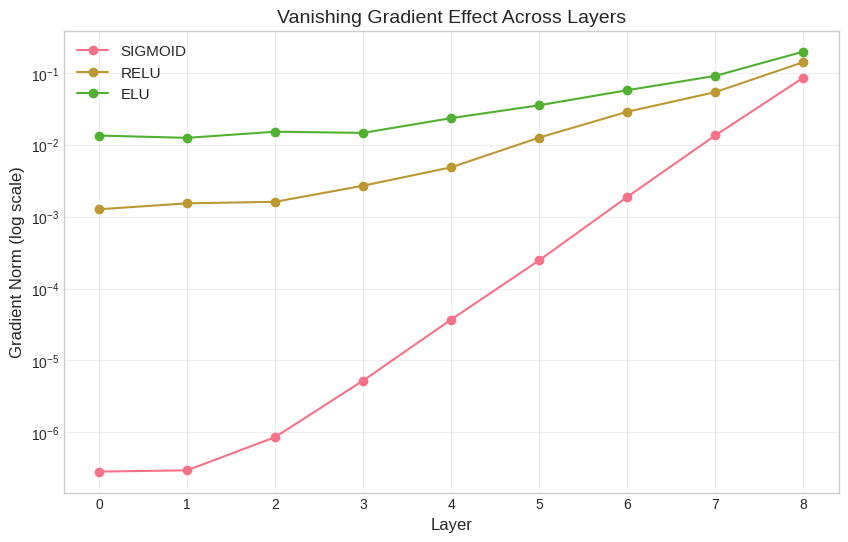

In [ ]:
def create_deep_network(activation_type, depth=8):
    layers = []
    for _ in range(depth):
        layers.append(nn.Linear(50, 50))
        if activation_type == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation_type == 'relu':
            layers.append(nn.ReLU())
        elif activation_type == 'elu':
            layers.append(nn.ELU())
    layers.append(nn.Linear(50, 1))
    return nn.Sequential(*layers)

X_dummy = torch.randn(100, 50)
y_dummy = torch.randn(100, 1)

gradient_norms = {}
for activation in ['sigmoid', 'relu', 'elu']:
    model = create_deep_network(activation)
    loss = F.mse_loss(model(X_dummy), y_dummy)
    loss.backward()

    grads = [param.grad.norm().item() for name, param in model.named_parameters() if 'weight' in name and param.grad is not None]
    gradient_norms[activation] = grads

# Plot
plt.figure(figsize=(10, 6))
for act, norms in gradient_norms.items():
    plt.plot(range(len(norms)), norms, label=act.upper(), marker='o')
plt.xlabel("Layer")
plt.ylabel("Gradient Norm (log scale)")
plt.yscale("log")
plt.title("Vanishing Gradient Effect Across Layers")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
class ProblematicReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 100)
        self.l2 = nn.Linear(100, 50)
        self.l3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.l3(x)

model = ProblematicReLU()
with torch.no_grad():
    model.l1.bias.fill_(-2.0)
    model.l2.bias.fill_(-2.0)

X = torch.randn(1000, 2)
out1 = F.relu(model.l1(X))
out2 = F.relu(model.l2(out1))

dead_l1 = (out1 == 0).all(dim=0).sum().item()
dead_l2 = (out2 == 0).all(dim=0).sum().item()

print(f"Dead neurons in layer 1: {dead_l1}/{out1.shape[1]}")
print(f"Dead neurons in layer 2: {dead_l2}/{out2.shape[1]}")

Dead neurons in layer 1: 70/100
Dead neurons in layer 2: 50/50
